<center> 
    <h3>Bioinformatics 2nd Project</h3>
    <h1>"Multiple Sequence Alignment using Genetic Algorithm"</h1>
    <!-- <br> -->
    <h4></h4>
    <h3>Seyed Mohammad Hossein Hashemi</h3>
    <h5>March 2025</h5>
    <h1></h1>

</center>

In [98]:
import random
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored
from tqdm import tqdm

The module below is the same module we used in the course excercises

In [47]:
def fasta_cleaner(path):
    """Helper function that cleans and extracts the ID and sequences from FASTA files."""
    raw_data = {}
    seq_counter = 1  # For default IDs

    with open(path, "r") as file:
        lines = file.readlines()
        for i in range(len(lines)):
            lines[i] = lines[i].rstrip("\n")
            
            if lines[i].startswith(">"):
                header = lines[i].lstrip(">")
                
                # Handlign the cases where there are no headers
                if not header.strip():
                    header = f"Seq{seq_counter}"
                    seq_counter += 1
                raw_data[header] = ""
            
            else:
                last_key = list(raw_data.keys())[-1]
                raw_data[last_key] += lines[i]
    
    return raw_data

In [84]:
def initialize_population(sequences, pop_size):
    """Create initial population with random gaps, ensuring equal lengths."""
    # Init a sequence with the length 1.2 the size of longest sequence
    max_len = int(max(len(seq) for seq in sequences) * 1.20)
    population = []
    
    for _ in range(pop_size):
        # for each sample of population (sequence)
        individual = []
        for seq in sequences:
            aligned_seq = list(seq)
            # add enough gaps in random positions and make them all have same size
            gaps_needed = max_len - len(aligned_seq)
            for _ in range(gaps_needed):
                pos = random.randint(0, len(aligned_seq))
                aligned_seq.insert(pos, '-')

            # append the result into a list (sample)    
            individual.append(''.join(aligned_seq))
            # and append the sample to the population
        population.append(individual)

        
    return population

In [85]:
def score_alignment(sequences):
    """Calculate score for an alignment."""
    score = 0
    seq_length = len(sequences[0])
    
    # Scoring parameters
    MATCH_SCORE = 2
    MISMATCH_SCORE = -1
    GAP_PENALTY = -2

    # sanity check! whether all the samples have same length
    if not all(len(seq) == seq_length for seq in sequences):
        return float('-inf')

    # for each index of all sequence
    for i in range(seq_length):
        # collect all their values and put it in a list
        column = [seq[i] for seq in sequences]

        # now for each index in that list (a column)
        for j in range(len(column)):
            for k in range(j + 1, len(column)):
                # for each time that index matched the next indexes and they are both gaps (aligned vertically but with gap)
                if column[j] == '-' or column[k] == '-':
                    if column[j] == column[k]:
                        # move to the next index (column) and penalize the alignment score
                        continue
                    score += GAP_PENALTY
                    
                elif column[j] == column[k]: # same logic with Match and Mismatch
                    score += MATCH_SCORE
                else:
                    score += MISMATCH_SCORE
                    
    return score

In [86]:
def crossover(parent1, parent2):
    """Perform crossover between two parents."""
    child1, child2 = [], []
    crossover_point = random.randint(0, len(parent1[0]))
    
    for seq1, seq2 in zip(parent1, parent2):
        c1 = seq1[:crossover_point] + seq2[crossover_point:]
        c2 = seq2[:crossover_point] + seq1[crossover_point:]
        child1.append(c1)
        child2.append(c2)
    
    return child1, child2


In [87]:
def mutate(individual, mutation_rate):
    """Mutate an individual by adding/removing gaps"""
    max_len = len(individual[0])
    mutated = []

    # for each index of a sample (Sequence) independent from the other indexes
    for seq in individual:
        seq_list = list(seq)
        # gives a random chance of getting mutated 
        if random.random() < mutation_rate:
            # if that chance is below the threshold, then we have a mutation

            # the mutation occurus in two way
            if random.random() < 0.5 and '-' in seq_list:
                # 50 perecent of times a random gap is removed from the sequence
                gap_pos = seq_list.index('-')
                seq_list.pop(gap_pos)
                seq_list.append('-')
            else:
                # rest of the times a random gap is added to the sequence
                pos = random.randint(0, len(seq_list))
                seq_list.insert(pos, '-')

                # Just to prevent further problems, here we check the mutation wont make the sequence surpass the len limmit
                if len(seq_list) > max_len:
                    gap_pos = seq_list.index('-', pos + 1) if '-' in seq_list[pos + 1:] else seq_list.index('-')
                    seq_list.pop(gap_pos)

        # append it back to the next gen
        mutated.append(''.join(seq_list))

        
    return mutated

In [92]:
def genetic_algorithm(sequences, pop_size, generations, mutation_rate):
    """Evolve a population of alignments to find the best one.
    """
    avg_fitness_per_gen = []
    
    # initial a random population
    population = initialize_population(sequences, pop_size)
    for _ in tqdm(range(generations)):
        # get the fitness score each alignment and sort their scores
        scores = [(ind, score_alignment(ind)) for ind in population]
        scores.sort(key=lambda x: x[1], reverse=True)  
        
        # Elitism (onlt the 1st quarter is taken)
        elite_size = pop_size // 4
        new_population = [ind for ind, _ in scores[:elite_size]]

        # Calculate and store the average fitness for this generation
        fitness_values = [score for _, score in scores]  
        avg_fitness = sum(fitness_values) / len(fitness_values) 
        avg_fitness_per_gen.append(avg_fitness)
        
        # how many offsprings we need ?
        num_children_needed = pop_size - elite_size
        num_pairs = num_children_needed // 2  # Each cv makes 2 offsprings
        
        
        for _ in range(num_pairs):
            # Select two parents from the top half
            parent1, parent2 = random.choices(scores[:pop_size//2], k=2)
            child1, child2 = crossover(parent1[0], parent2[0]) # cross over
            # mutate
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])
        
        # Exception Hanlding: when we need odd number offsprings
        if num_children_needed % 2 == 1:
            parent1, parent2 = random.choices(scores[:pop_size//2], k=2)
            child1, _ = crossover(parent1[0], parent2[0])  # add one and make it even
            child1 = mutate(child1, mutation_rate)
            new_population.append(child1)
        
        #here comes the next gen
        population = new_population[:pop_size]
    # keep the track of the best
    best_alignment = max(population, key=score_alignment)

    
    return best_alignment, avg_fitness_per_gen

In [108]:
def print_colored_by_group(alignment):
    """Protein Bob Ross: respects the aa PhysioChemical Groupings"""
    
    HYDROPHOBIC = set('AILMFWPV')  
    CHARGED = set('DEKRH')         
    POLAR = set('STNQ')            
    SPECIAL = set('GCY')
    
    for i, seq in enumerate(alignment, 1):
            colored_seq = ''
            for char in seq:  
                if char == '-':  # Gaps are white
                    colored_seq += colored(char, 'white')
                    
                elif char in HYDROPHOBIC:  
                    colored_seq += colored(char, 'blue')
                    
                elif char in CHARGED:  
                    colored_seq += colored(char, 'red')
                    
                elif char in POLAR:  
                    colored_seq += colored(char, 'green')
                    
                elif char in SPECIAL:  
                    colored_seq += colored(char, 'yellow')
                    
                else:  # typos
                    colored_seq += colored(char, 'grey')
                    
            print(f"{colored_seq}\n")

In [105]:
def print_colored_alignment(alignment):
    """Display the alignment with colors based on alignment status.
    """
    # For each column, determine the most common character (ignoring gaps)
    seq_length = len(alignment[0])  
    
    majority_chars = []
    for i in range(seq_length):
        column = [seq[i] for seq in alignment]  
        # Count non-gap characters
        non_gaps = [char for char in column if char != '-']
        # If there are non-gap characters
        if non_gaps:  
            majority_char = Counter(non_gaps).most_common(1)[0][0]  # Most frequent
        
        else:
            majority_char = '-'  # All gaps (default)
        majority_chars.append(majority_char)
    
    # colors are given based on alignment with majority
    for i, seq in enumerate(alignment, 1):
        colored_seq = ''
        for j, char in enumerate(seq):  
            if char == '-':  # Gaps are  white
                colored_seq += colored(char, 'white')
                # Matches majority character
            elif char == majority_chars[j]:  
                colored_seq += colored(char, 'green')
                
            else:  # Doesn’t match majority character
                colored_seq += colored(char, 'yellow')
                
        print(f"{colored_seq}\n")

In [110]:
def main(fasta_file, pop_size, generations, mutation_rate):
    """Main function to run MSA."""
    sequence_dict = fasta_cleaner(fasta_file)
    sequences = list(sequence_dict.values())
    alignment, history = genetic_algorithm(sequences, pop_size, generations, mutation_rate)

    # Just for logging ...
    print(f"Alignment score: {score_alignment(alignment)}")
    print("\nGREEN: Aligned with the most frequent\nYELLOW: Not aligned with the most frequent\nWHITE: gap\n")
    print_colored_alignment(alignment)
    
    print("="*150)
    print("\nSIMMILAR COLORS INDICATE SIMILAR PHYSIOCEHMICAL GROUPING:\n")
    print_colored_by_group(alignment)
    
    print(f"Alignment score: {score_alignment(alignment)}")

    return history

In [117]:
fasta_file_path = "test_cases.fasta"
history = main(fasta_file_path, pop_size= 200, generations=2000, mutation_rate=0.20)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:52<00:00, 17.84it/s]

Alignment score: 138

GREEN: Aligned with the most frequent
YELLOW: Not aligned with the most frequent
WHITE: gap

GKVGAHAGEYY-GEYGAE-AL-EFLSF-P--Y--FPHFDLSHGSS-HGSAQVKVA-DALTNDAL-TNAVAA-VVDDM-PNALSALLHAHKLRVDPVDPVNFVNKLLSCLLVTLAAHAAHLPAEP TP AVHASSLDLDKFLAASVSVVLTSKYR  -

MVLSPPADKTNKTNVKAAAWG-GAHAG---YGA-EALERMMFLSSFPTTKKTY-P-HDLSS-FDLSHGSAQ-VGHG KKVAADALNAAVAAHV-D-DVVD-DS-ALS--LHAAAHKHAHKLRVVVNNFKLLSHCLLLVTTLAAHLHHLPAEFTP  -

MVLS-PADKTN-TNVKAA-WG--AHAG-E--GAAEALER-MFLSSFPTTKKTY-F-P-FDL-FD-SHGSAQ-VK-G-HG KKVADNNAVAHVV-D-DDMSHCL--MSHLLVTLAAHHAHLPAEP PP AVH-ASLDLDKFL-ASVSTVLTSKYR---

MVLS-PADKTN-TNVKAAAWGKGAHAG-E--GA-EALERMFFLSMFLSFPPT VA-DALTNDAL-TNA-VAHVVDDM-PNALSA-LHAHKLRV-DVDPVN-LL-LLSCLLVTLAAHHAHLPAEP-PP AVH-ASLDLDKFLAASVSTVLTSKYR---


SIMMILAR COLORS INDICATE SIMILAR PHYSIOCEHMICAL GROUPING:

GKVGAHAGEYY-GEYGAE-AL-EFLSF-P--Y--FPHFDLSHGSS-HGSAQVKVA-DALTNDAL-TNAVAA-VVDDM-PNALSALLHAHKLRVDPVDPVNFVNKLLSCLLVTLAAHAAHLPAEP TP AVHASSLDLDKFLAASVSVVLTSKYR  -

MVLSPPADKTNKTNVKAAAWG-GAHAG---

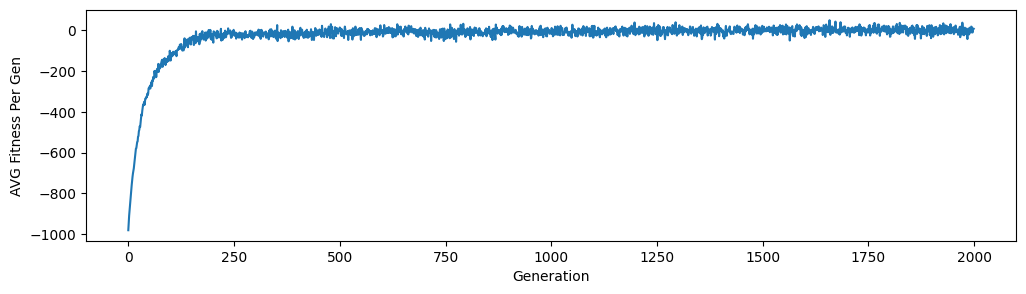

In [118]:
plt.figure(figsize=(12,3))
plt.plot(history)
plt.xlabel('Generation')
plt.ylabel('AVG Fitness Per Gen')
plt.show()